## 지진관측기록 시각화(Heat map)

In [1]:
'''
xlsx file to 
'''
import jpype
import asposecells
jpype.startJVM()
from asposecells.api import Workbook, SaveFormat

workbook = Workbook("xlsx_file\\historical_earthquake.xlsx")
workbook.save("csv_file\\historical_earthquake.csv", SaveFormat.CSV)


workbook = Workbook("xlsx_file\\국내지진목록_1978-01-01_2016-10-01.xls")
workbook.save("csv_file\\국내지진목록_1978-01-01_2016-10-01.csv", SaveFormat.CSV)
workbook = Workbook("xlsx_file\\국내지진목록_2016-10-02_2019-12-31.xls")
workbook.save("csv_file\\국내지진목록_2016-10-02_2019-12-31.csv", SaveFormat.CSV)
workbook = Workbook("xlsx_file\\국내지진목록_2020-01-01_2023-06-16.xls")
workbook.save("csv_file\\국내지진목록_2020-01-01_2023-06-16.csv", SaveFormat.CSV)


In [ ]:
'''
2 ~ 1904 Earthquake
가중치 : 진도 -> 가속도(PGA)
'''
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',  None)

Rom = {'Ⅰ' : 0.035, 'Ⅱ' : 0.15, 'Ⅲ' : 0.495, 'Ⅳ' : 1.66, 'Ⅴ' : 4.71, 'Ⅵ' : 10.795, 'Ⅶ' : 23.195, 'Ⅷ' : 49.835, 'Ⅸ' : 107.075, 'Ⅹ' : 146.14, '-' : 0, '?' : 0}     # 진도 rom num : arabic num


df_his = pd.read_csv("csv_file\\historical_earthquake.csv", encoding='utf-8')
df_his = df_his.rename(columns= df_his.iloc[0])
df_his = df_his.drop(df_his.index[0])
df_his = df_his.drop(df_his.index[len(df_his['진도']) - 1])             # column, 마지막 값(없는 값) 정리

df_his['일자(양력/음력)'] = df_his['일자(양력/음력)'].astype('str')         # 양력만 추출
df_his_date = df_his['일자(양력/음력)'].str.split('/')
df_his['일자'] = df_his_date.str.get(0)

j = 1                                                                 # 진도 arabic num 변환
for i in df_his['진도']:
    if len(i) == 1:
        temp = Rom[i]
        df_his['진도'][j] = temp
    elif len(i) == 3:
        temp = i[2]
        temp = Rom[temp]
        df_his['진도'][j] = temp

    j += 1

df_his['위도/경도'] = df_his['위도/경도'].astype('str')                     # 위도 , 경도 따로 추출, 실수화
df_his = df_his[df_his['위도/경도'] != '진앙미정 / 진앙미정']
df_his_loc = df_his['위도/경도'].str.split('/')
df_his['위도'] = df_his_loc.str.get(0)
df_his['경도'] = df_his_loc.str.get(1)

df_his = df_his.drop(['일자(양력/음력)', '위도/경도', '기사(출전)', '번호', '감진반경(km)'], axis= 'columns')       # column 최종 정리

import folium
from folium import plugins
latitude, longitude = 35.9078, 127.7669                                 # 대한민국의 좌표
S_korea = folium.Map(location = [latitude, longitude], zoom_start = 7)
df_his['위도'] = df_his['위도'].astype('float')
df_his['경도'] = df_his['경도'].astype('float')
df_his['진도'] = df_his['진도'].astype('float')
S_korea.add_child(plugins.HeatMap(zip(df_his['위도'], 
                                      df_his['경도'],
                                    df_his['진도']), radius= 15))

df_his.to_csv("csv_file\\df_his.csv")   

In [2]:
'''
1904 03 03 ~ 2023 05 25 Earthquake
가중치 : 규모 -> Energy
'''
import pandas as pd
import numpy as np
def RecEqDf(file_name):
    df = pd.read_csv(file_name, encoding= 'utf-8')
    df = df.rename(columns= df.iloc[0])
    df = df.drop(df.index[0:1])
    df['발생시각'].replace('', np.nan, inplace = True)
    df.dropna(subset = ['발생시각'], inplace = True)
    return df
    
dfRec1 = RecEqDf("csv_file\\국내지진목록_1978-01-01_2016-10-01.csv")
dfRec2 = RecEqDf("csv_file\\국내지진목록_2016-10-02_2019-12-31.csv")
dfRec3 = RecEqDf("csv_file\\국내지진목록_2020-01-01_2023-06-16.csv")

df_rec = pd.concat([dfRec1, dfRec2, dfRec3], ignore_index= True)

df_rec.to_csv("csv_file\\Recent_earthquake.csv", encoding="utf-8-sig")

df_rec = df_rec.drop(['번호', '발생시각', '위치', '지도보기', '상세정보\n(진도 등)', '최대\n진도', '깊이(km)'], axis= 'columns')
df_rec['위도'] = df_rec['위도'].astype('str')
rec_lat = df_rec['위도'].str.split(' ')
df_rec['위도'] = rec_lat.str.get(0)

df_rec['경도'] = df_rec['경도'].astype('str')
rec_lat = df_rec['경도'].str.split(' ')
df_rec['경도'] = rec_lat.str.get(0)

j = 0
for i in df_rec['규모']:                        # 규모 -> 에너지 환산 :  https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=gumdansan21&logNo=130135121090
    temp = (11.8 + 1.5 * float(i))
    df_rec.loc[j,'에너지'] = (10 ** temp) * (10 ** -3)
    j += 1
    
df_rec = df_rec[df_rec['위도'] != '-']


import folium                                                            # heatmap 
from folium import plugins
latitude, longitude = 35.9078, 127.7669                                 # 대한민국의 좌표
S_korea = folium.Map(location = [latitude, longitude], zoom_start = 7)

df_rec['위도'] = df_rec['위도'].astype('float')
df_rec['경도'] = df_rec['경도'].astype('float')

S_korea.add_child(plugins.HeatMap(zip(df_rec['위도'],
                                      df_rec['경도'],
                                      df_rec['에너지']), radius= 15))

In [4]:
df_rec

,규모,위도,경도,에너지
0,0.6,35.76,129.17,5.011872e+09
1,0.4,35.75,129.19,2.511886e+09
2,0.6,35.75,129.19,5.011872e+09
3,0.4,35.76,129.19,2.511886e+09
4,0.6,35.76,129.19,5.011872e+09
...,...,...,...,...
10666,1.2,35.96,126.19,3.981072e+10
10667,1.7,36.70,127.52,2.238721e+11
10668,1.0,36.05,126.62,1.995262e+10
10669,1.2,36.15,127.60,3.981072e+10


## 과거 지진 데이터 규모값 있는 html crawling + 최근 지진 데이터 합치기
https://www.seismosoc.org/Publications/BSSA_html/bssa_96-3/05050-esupp/05050-esupp_1.html<br>
값이 들어있는 것은 공통적으로
```html
<td>
```
 형식을 지니고 있음<br>
 <br>
 df_his + df_rec -> new dataframe<br>
 columns : year, month, day, lat, long, ml<br>
<br>
1392 ~ 2023 data

In [5]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd

html = urlopen("https://www.seismosoc.org/Publications/BSSA_html/bssa_96-3/05050-esupp/05050-esupp_1.html")
bsObject = BeautifulSoup(html, "html.parser")
data_ml = bsObject.find_all('td', class_ = False)

list_year = []      # 1
list_month = []     # 2
list_day = []       # 3
list_lat = []       # 4
list_long = []      # 5
list_ml = []        # 7

n = 0
for data in data_ml:
    k = n % 10
    if k == 1:
        list_year.append(data.get_text())
    elif k == 2:
        list_month.append(data.get_text())
    elif k == 3:
        list_day.append(data.get_text())
    elif k == 4:
        list_lat.append(data.get_text())
    elif k == 5:
        list_long.append(data.get_text())
    elif k == 7:
        list_ml.append(data.get_text())
    n += 1

raw_data = {'year' : list_year,
            'month' : list_month,
            'day' : list_day,
            'lat' : list_lat,
            'long' : list_long,
            'ml' : list_ml}
dfHisML = pd.DataFrame(raw_data)


def split_data(col):
    df_rec[col] = df_rec[col].astype('str')
    rec = df_rec[col].str.split(' ')
    df_rec[col] = rec.str.get(0)

df_rec = pd.read_csv("csv_file\\Recent_earthquake.csv", encoding= 'utf-8')
df_rec = df_rec.drop(['번호', '위치', '지도보기', '상세정보\n(진도 등)', '최대\n진도', '깊이(km)'], axis= 'columns')

split_data('위도')
split_data('경도')
split_data('발생시각')

temp = df_rec['발생시각'].str.split('/')

list_year = temp.str.get(0).values.tolist()
list_month = temp.str.get(1).values.tolist()
list_day = temp.str.get(2).values.tolist()
list_lat = df_rec['위도'].values.tolist()
list_long = df_rec['경도'].values.tolist()
list_ml = df_rec['규모'].values.tolist()


raw_data = {'year' : list_year,
            'month' : list_month,
            'day' : list_day,
            'lat' : list_lat,
            'long' : list_long,
            'ml' : list_ml,}
dfRecML = pd.DataFrame(raw_data, dtype= object)

dfML = pd.concat([dfHisML, dfRecML], ignore_index= True)

dfML['year'] = dfML['year'].astype('int')



list_ml_erg = []
for i in dfML['ml']:                        # 규모 -> 에너지 환산 :  https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=gumdansan21&logNo=130135121090
    temp = (11.8 + 1.5 * float(i))
    list_ml_erg.append((10 ** temp) * (10 **- 19))              # 단위 : TJ
dfML['ml_erg'] = list_ml_erg

dfML = dfML.drop(dfML[dfML['year'] <= 1392].index)
dfML['lat'] = dfML['lat'].dropna()
dfML['long'] = dfML['long'].dropna()
dfML = dfML.drop(dfML[(dfML['lat'] == '-') | (dfML['long'] == '-')].index)
dfML.to_csv("csv_file\\earthquake_ML.csv")

## 좌표에 따른 시군구 위치 산출

In [6]:
import pandas as pd
import json
import geopandas as gpd
from fiona.crs import from_epsg
sigungu_geojson = 'json_file/SIGUNGU_2302.json'
dfML = pd.read_csv("csv_file\\earthquake_ML.csv")
dfML = dfML.drop(['Unnamed: 0'], axis= 'columns')

with open(sigungu_geojson,'r',encoding="utf-8") as f:
    json_data = json.load(f)

gdf_pt_geom = gpd.points_from_xy(dfML.long, dfML.lat)
eq_gpd = gpd.GeoDataFrame(dfML, geometry=gdf_pt_geom, crs=from_epsg(4326))              # dfML 좌표


sigungu_gdf = gpd.read_file(sigungu_geojson)
sigungu_gdf = gpd.GeoDataFrame(sigungu_gdf, geometry=sigungu_gdf['geometry'], crs=from_epsg(4326))          # 시군구 geodataframe

place_data = gpd.sjoin(eq_gpd, sigungu_gdf, how = "inner")
for i in range(len(sigungu_gdf)): #시군구별 평균 구하기
    ml_erg = place_data[sigungu_gdf['SIG_CD'][i] == place_data['SIG_CD']]['ml_erg'].sum() / 1000
    ml_max = place_data[sigungu_gdf['SIG_CD'][i] == place_data['SIG_CD']]['ml'].max()

    sigungu_gdf.loc[i,"ml_erg"] = ml_erg
    sigungu_gdf.loc[i,"ml_max"] = ml_max

In [7]:
sigungu_gdf

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,CTP_KOR_NM,geometry,ml_erg,ml_max
0,11110,Jongno-gu,종로구,서울특별시,"POLYGON ((127.01179 37.58157, 127.00864 37.580...",3.548134e-10,0.5
1,11140,Jung-gu,중구,서울특별시,"POLYGON ((127.02337 37.57191, 127.01708 37.569...",5.011872e-10,0.6
2,11170,Yongsan-gu,용산구,서울특별시,"POLYGON ((127.00899 37.54413, 127.00502 37.546...",0.000000e+00,NaN
3,11200,Seongdong-gu,성동구,서울특별시,"POLYGON ((127.07238 37.55996, 127.07086 37.560...",0.000000e+00,NaN
4,11215,Gwangjin-gu,광진구,서울특별시,"POLYGON ((127.11525 37.55676, 127.11230 37.559...",0.000000e+00,NaN
...,...,...,...,...,...,...,...
245,48870,Hamyang-gun,함양군,경상남도,"POLYGON ((127.85639 35.56941, 127.85493 35.573...",8.645595e-04,4.7
246,48880,Geochang-gun,거창군,경상남도,"POLYGON ((128.07736 35.83966, 128.07421 35.838...",4.849559e-03,5.2
247,48890,Hapcheon-gun,합천군,경상남도,"POLYGON ((128.16371 35.77719, 128.16044 35.778...",1.006308e+00,6.4
248,50110,Jeju-si,제주시,제주특별자치도,"MULTIPOLYGON (((126.63685 33.92129, 126.63761 ...",3.162426e-02,5.8


In [9]:
sigungu_gdf.ml_max.dropna()

0      0.5
1      0.6
6      5.8
7      6.7
11     1.1
      ... 
245    4.7
246    5.2
247    6.4
248    5.8
249    2.6
Name: ml_max, Length: 195, dtype: float64

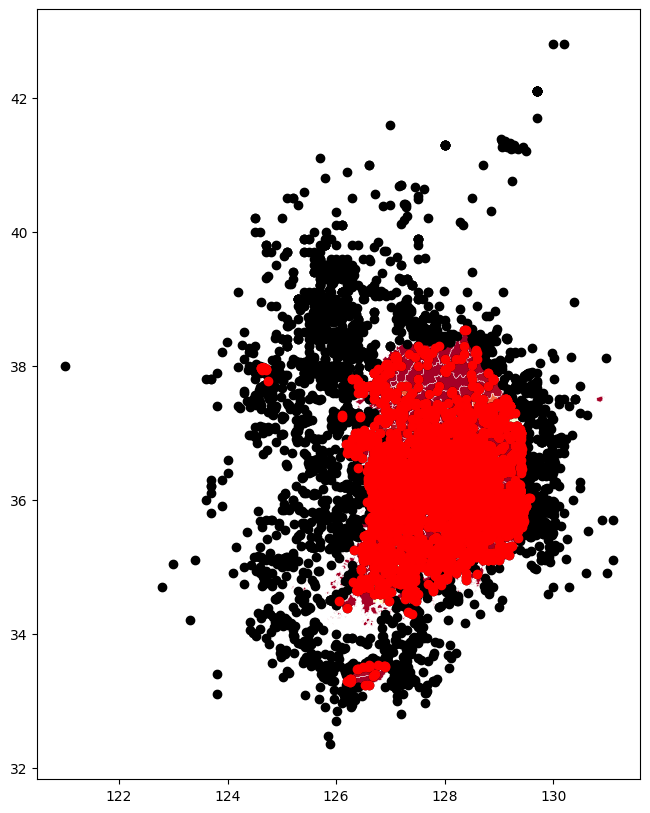

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sigungu_gdf.plot(column='ml_erg',cmap='RdYlBu', ax=ax, edgecolor='white', linewidth=0.3)

eq_gpd.plot(ax=ax, color='black')
place_data.plot(ax=ax, color='red')
plt.show()

In [12]:
 place_data

,year,month,day,lat,long,ml,ml_erg,geometry,index_right,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,CTP_KOR_NM
0,1393,3,20,37.60,127.00,3.5,0.011220,POINT (127.00000 37.60000),7,11290,Seongbuk-gu,성북구,서울특별시
1,1395,1,3,37.60,127.00,3.5,0.011220,POINT (127.00000 37.60000),7,11290,Seongbuk-gu,성북구,서울특별시
2,1397,4,2,37.60,127.00,3.5,0.011220,POINT (127.00000 37.60000),7,11290,Seongbuk-gu,성북구,서울특별시
3,1397,12,10,37.60,127.00,3.5,0.011220,POINT (127.00000 37.60000),7,11290,Seongbuk-gu,성북구,서울특별시
4,1398,3,22,37.60,127.00,3.5,0.011220,POINT (127.00000 37.60000),7,11290,Seongbuk-gu,성북구,서울특별시
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11503,2021,04,12,35.82,128.57,1.5,0.000011,POINT (128.57000 35.82000),47,27290,Dalseo-gu,달서구,대구광역시
12147,2020,06,14,35.86,128.49,1.1,0.000003,POINT (128.49000 35.86000),47,27290,Dalseo-gu,달서구,대구광역시
12511,2020,02,04,35.86,128.50,1.3,0.000006,POINT (128.50000 35.86000),47,27290,Dalseo-gu,달서구,대구광역시
12400,2020,03,29,35.17,129.02,1.5,0.000011,POINT (129.02000 35.17000),29,26230,Busanjin-gu,부산진구,부산광역시


In [13]:
place_data['ml'][place_data['SIG_KOR_NM'] == '종로구']

4572    0.5
Name: ml, dtype: float64